In [1]:
import sys, os
import argparse
import re
import time
from Deconvolution.BLADE import Framework
import numpy as np
from numpy import transpose as t
import itertools
import pickle
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error 
import pandas as pd
from tqdm import trange,tqdm
# modules for visualization
import qgrid
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import cycler
from sklearn.metrics import r2_score
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
import imblearn

## Read in cell type compositions from best deconvolution and fga information
- read in BayesPrism top 100DEGs deconvolution cell type fractions
- read in fga data table extracted from Kari's plots

In [2]:
# read in best decon cell type frac results file
# BayesPrism top100DEGs
res_prevail = pd.read_csv("/home/cke/Real/TCGAResults/BayesPrism/celltypefrac_BP_fullpipeline_real_Jul28_real_top100DEGs.csv",index_col=0)
res_prevail['sample'] = res_prevail.index.tolist()
res_prevail['sample'] = res_prevail['sample'].str.rstrip('A')
# res_prevail

In [3]:
# read in fga data table from Kari's plots
fga_Kari = pd.read_csv("/home/cke/KariPDF/fga_table.csv",header=None)
fga_Kari.columns = ['sample','fga']
# fga_Kari

In [4]:
# using cellularity extracted from Kari's plots pdf 
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari = cellularity_Kari[cellularity_Kari['cellularity']<1.0]
# cellularity_Kari

In [5]:
df_merged = pd.merge(res_prevail,pd.merge(cellularity_Kari,fga_Kari,on='sample'))
# Merging fga + cell type fractions 

### Merge fga + cell type fractions and add FGA status with cutoff 0.2

In [6]:
def define_FGA(fga):
    if fga > 0.2:
        return 'High'
    else:
        return 'Silent'
df_merged['FGA_status'] = df_merged['fga'].apply(define_FGA)

In [7]:
df_merged

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status
0,2.411960e-06,8.428294e-06,0.021554,0.025049,0.027368,0.000282,8.261100e-03,2.307278e-05,0.005746,0.911705,TCGA-BB-4224-01,0.59,0.526,High
1,2.946835e-04,7.654396e-05,0.014944,0.006623,0.025805,0.001518,2.656234e-05,2.832948e-03,0.005875,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent
2,3.293064e-03,1.011790e-03,0.035880,0.382291,0.135420,0.000807,4.207604e-04,3.151934e-07,0.010174,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent
3,5.709435e-03,3.259289e-03,0.037323,0.027008,0.052619,0.000677,1.216315e-02,2.098187e-06,0.028711,0.832527,TCGA-CN-5374-01,0.36,0.572,High
4,1.749130e-06,8.105416e-07,0.090115,0.223870,0.017085,0.000501,1.159842e-01,1.288752e-06,0.003212,0.549231,TCGA-CQ-6227-01,0.26,0.650,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6.054611e-03,1.846723e-06,0.062586,0.095856,0.043977,0.000638,5.265638e-04,1.956283e-01,0.000798,0.593934,TCGA-CN-6010-01,0.36,0.736,High
480,2.447322e-07,5.819924e-06,0.046802,0.340756,0.052835,0.000410,2.725393e-07,5.001734e-07,0.007906,0.551284,TCGA-CV-7235-01,0.40,0.778,High
481,1.076841e-03,1.317807e-04,0.031584,0.020308,0.012922,0.000071,3.760127e-04,3.780077e-04,0.006510,0.926642,TCGA-CX-7086-01,0.61,0.642,High
482,2.015405e-02,1.773918e-03,0.049495,0.094740,0.074611,0.003291,9.269963e-05,2.502143e-06,0.022013,0.733826,TCGA-P3-A6SW-01,0.28,0.545,High


### Get concensus HPV positive sample annotations from Nulton et al. 2017 and official TCGA GDC phenodata

In [8]:
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')
TCGA_pheno['hpv_status']=''
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'
TCGA_pheno['hpv_status'].value_counts()

            491
Negative     98
Positive     23
Name: hpv_status, dtype: int64

In [9]:
Nulton = pd.read_excel("/home/cke/Nulton 2017 - supplementary.xlsx",sheet_name=1)
# Nulton

/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
TCGA_pheno['sample'] = TCGA_pheno['submitter_id.samples'].str.rsplit("-",n=1,expand=True)[0]

In [11]:
list_pos_tcgaPheno = TCGA_pheno[TCGA_pheno['hpv_status']=='Positive']['sample'].tolist()
list_pos_Nulton = Nulton['HNSCC Barcode'].tolist()

In [12]:
set_pos = set(list_pos_Nulton+list_pos_tcgaPheno)
print("We gathered",len(set_pos),"Positive samples from two source") 

We gathered 81 Positive samples from two source


### Create merged data table for HPV pos and neg groups

In [13]:
df_merged_HPVpos = df_merged.copy()
df_merged_HPVpos['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_HPVpos = df_merged_HPVpos[df_merged_HPVpos['sample_match'].isin(set_pos)]
# df_merged_HPVpos

In [14]:
df_merged_HPVneg = df_merged.copy()
df_merged_HPVneg['sample_match'] = df_merged['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_HPVneg = df_merged_HPVneg[~df_merged_HPVneg['sample_match'].isin(set_pos)]
# df_merged_HPVneg

### Get relative immune cell type fractions as a function of nun-malignant cells


In [16]:
df_merged_HPVpos_relative = df_merged_HPVpos.copy()
df_merged_HPVpos_relative.iloc[:,:9] = df_merged_HPVpos_relative.iloc[:,:9].div(df_merged_HPVpos_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVpos_relative

In [17]:
df_merged_HPVneg_relative = df_merged_HPVneg.copy()
df_merged_HPVneg_relative.iloc[:,:9] = df_merged_HPVneg_relative.iloc[:,:9].div(df_merged_HPVneg_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_relative

### Copare cell type compositions between samples with two CNA status 
-	Copy number alteration groups on the x-axis and again run all cell types (CNA-silent, nonsilent with cut-off FGA 0.20, we could talk about other cut-offs later as well)

In [18]:
print("Number of CNA-high and CNA-silent samples that are also HPV-")
df_merged_HPVneg['FGA_status'].value_counts()

Number of CNA-high and CNA-silent samples that are also HPV-


High      358
Silent     58
Name: FGA_status, dtype: int64

In [140]:
# comparison of CNA-silent vs –high of only oral cavity tumors. 
# This is a ‘’cleaner’’ comparison since anatomical site wouldn’t influence the results now, only looking at difference between silent and nonsilent in oral cavity. 
df_merged_HPVneg_fga_site_relative_OC = df_merged_HPVneg_fga_site_relative[df_merged_HPVneg_fga_site_relative['primary_site']=='Oral Cavity']

In [141]:
df_merged_HPVneg_melt = pd.melt(df_merged_HPVneg_fga_site_relative_OC,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
df_merged_HPVneg_melt

,FGA_status,variable,value
0,High,B-cell,0.000027
1,High,B-cell,0.002827
2,High,B-cell,0.002827
3,High,B-cell,0.046388
4,Silent,B-cell,0.000070
...,...,...,...
2345,High,tumor,0.551284
2346,High,tumor,0.551284
2347,High,tumor,0.926642
2348,High,tumor,0.663102


Text(0, 0.5, 'Cell type fractions')

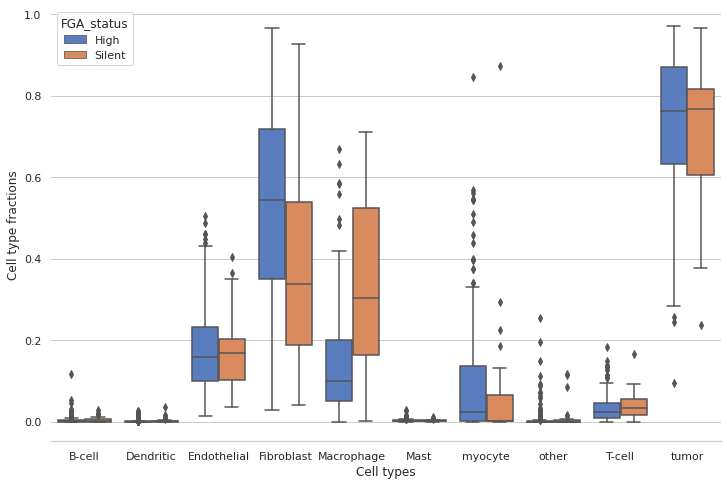

In [151]:
plt.subplots(figsize=(12,8))
sns.boxplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_melt)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

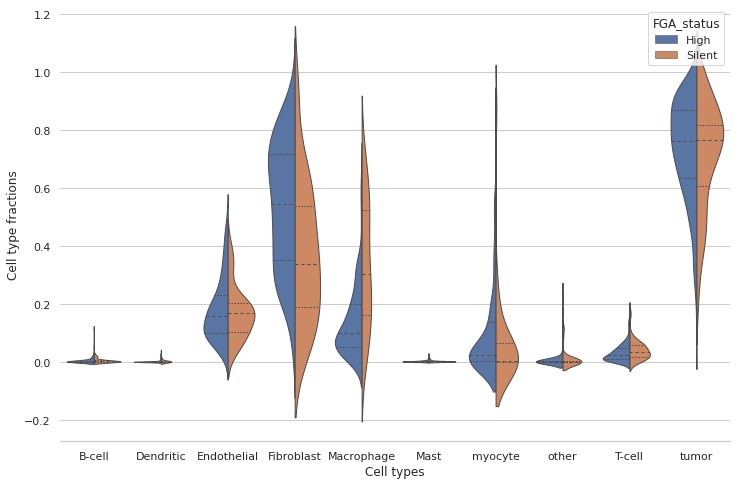

In [152]:
plt.subplots(figsize=(12,8))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='FGA_status',data=df_merged_HPVneg_melt,split=True, inner="quart", linewidth=1,)
sns.despine(left=True)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

### Visualizations below requires resampling to alleviate the effect of class-imbalance!
#### We do not wish to lose any valuable CNA-high samples, therefore use SMOTE (Synthetic Minority Oversampling) algorithm to upsample CNA silent group, as a result we have equal number of CNA-high and silent samples

In [144]:
sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist()
list_col.append('fga')

X_train, y_train = sm.fit_resample(df_merged_HPVneg_fga_site_relative_OC.loc[:,list_col].to_numpy(),df_merged_HPVneg_fga_site_relative_OC['FGA_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 398
High      199
Silent    199
Name: FGA_status, dtype: int64


In [145]:
df_afterSMOTE = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE['FGA_status'] = y_train
# df_afterSMOTE

In [146]:
df_afterSMOTE_melt = pd.melt(df_afterSMOTE,id_vars='FGA_status',value_vars=df_merged_HPVneg_fga_site_relative_OC.columns[:10].tolist())
# df_afterSMOTE_melt

In [147]:
df_afterSMOTE_melt_log = df_afterSMOTE_melt.copy()
df_afterSMOTE_melt_log['value'] = df_afterSMOTE_melt_log['value'].apply(np.log)

### Draw a categorical scatterplot to show each observation, cell type fractions are log transformed to speed up visualization and spread data points out

[Text(0.5, 0, 'log-transfomed Cell type percentage SWARMs across CNA status after SMOTE resampling')]

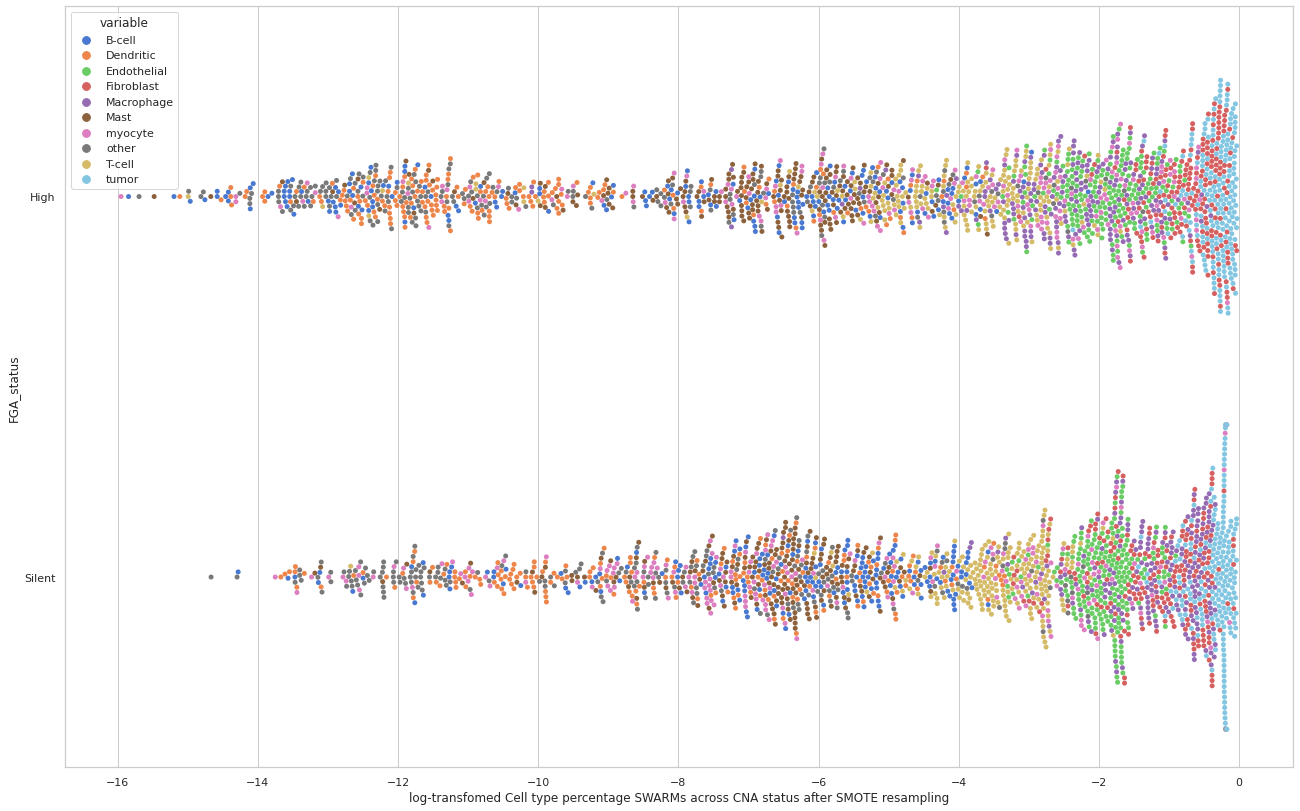

In [150]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,14))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_log, x="value", y="FGA_status", hue="variable")
ax.set(xlabel="log-transfomed Cell type percentage SWARMs across CNA status after SMOTE resampling")

### From which anatomical sites are the HPV-negative CNA-silent cases? 
> How many oral cavity, how many hypopharynx etc? Make a table of the silent cases and which anatomical locations they are. 

In [131]:
df_merged_HPVneg_fga_site_relative = pd.merge(df_merged_HPVneg_relative,df_merged_sites_HPVneg_relative,left_on='sample_match',right_on='sample_match',suffixes=(None,'_sites'))
df_merged_HPVneg_fga_site_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,...,Fibroblast_sites,Macrophage_sites,Mast_sites,myocyte_sites,other_sites,T-cell_sites,tumor_sites,sample_sites,submitter_id.samples,primary_site
0,2.731707e-05,0.000095,0.244119,0.283693,0.309965,0.003196,9.356251e-02,2.613147e-04,0.065081,0.911705,...,0.283693,0.309965,3.196005e-03,9.356251e-02,2.613147e-04,0.065081,0.911705,TCGA-BB-4224-01,TCGA-BB-4224-01A,Oral Cavity
1,5.784423e-03,0.001777,0.063026,0.671513,0.237871,0.001418,7.390858e-04,5.536522e-07,0.017871,0.430702,...,0.671513,0.237871,1.418246e-03,7.390858e-04,5.536522e-07,0.017871,0.430702,TCGA-CV-6943-01,TCGA-CV-6943-01A,Oropharynx
2,5.784423e-03,0.001777,0.063026,0.671513,0.237871,0.001418,7.390858e-04,5.536522e-07,0.017871,0.430702,...,0.037737,0.187612,7.045318e-03,2.792971e-01,2.022996e-01,0.076388,0.921584,TCGA-CV-6943-11,TCGA-CV-6943-11A,Oropharynx
3,2.826607e-03,0.000006,0.224973,0.256350,0.159039,0.000825,3.410992e-01,4.595136e-06,0.014877,0.680641,...,0.256350,0.159039,8.251030e-04,3.410992e-01,4.595136e-06,0.014877,0.680641,TCGA-CV-6959-01,TCGA-CV-6959-01A,Oral Cavity
4,2.826607e-03,0.000006,0.224973,0.256350,0.159039,0.000825,3.410992e-01,4.595136e-06,0.014877,0.680641,...,0.032906,0.087678,1.190790e-03,7.867833e-01,2.651689e-03,0.011271,0.580305,TCGA-CV-6959-11,TCGA-CV-6959-11A,Oral Cavity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,5.454056e-07,0.000013,0.104302,0.759402,0.117746,0.000915,6.073761e-07,1.114677e-06,0.017620,0.551284,...,0.108927,0.219053,6.397399e-07,4.695640e-04,5.361128e-01,0.000005,0.088587,TCGA-CV-7235-11,TCGA-CV-7235-11A,Oral Cavity
377,5.454056e-07,0.000013,0.104302,0.759402,0.117746,0.000915,6.073761e-07,1.114677e-06,0.017620,0.551284,...,0.759402,0.117746,9.147147e-04,6.073761e-07,1.114677e-06,0.017620,0.551284,TCGA-CV-7235-01,TCGA-CV-7235-01A,Oral Cavity
378,1.467926e-02,0.001796,0.430551,0.276839,0.176143,0.000974,5.125722e-03,5.152918e-03,0.088738,0.926642,...,0.276839,0.176143,9.739105e-04,5.125722e-03,5.152918e-03,0.088738,0.926642,TCGA-CX-7086-01,TCGA-CX-7086-01A,Oral Cavity
379,2.342538e-02,0.020461,0.180597,0.339735,0.222189,0.002712,1.743853e-01,1.268518e-05,0.036481,0.663102,...,0.201227,0.031910,7.942474e-03,4.895720e-01,8.799053e-02,0.002807,0.736862,TCGA-HD-A6HZ-11,TCGA-HD-A6HZ-11A,Oral Cavity


In [132]:
df_merged_HPVneg_fga_site_relative[df_merged_HPVneg_fga_site_relative['FGA_status']=='Silent']['primary_site'].value_counts()

Oral Cavity    36
Larynx          5
Oropharynx      3
Hypopharynx     1
Name: primary_site, dtype: int64

In [133]:
# table
df_merged_HPVneg_fga_site_relative[df_merged_HPVneg_fga_site_relative['FGA_status']=='Silent'][['sample_match','primary_site']].reset_index(drop=True)

,sample_match,primary_site
0,TCGA-CV-6943,Oropharynx
1,TCGA-CV-6943,Oropharynx
2,TCGA-F7-A61V,Oropharynx
3,TCGA-CQ-7063,Oral Cavity
4,TCGA-HD-A4C1,Oral Cavity
5,TCGA-BA-5556,Oral Cavity
6,TCGA-KU-A66S,Larynx
7,TCGA-CN-A63V,Oral Cavity
8,TCGA-CQ-5325,Oral Cavity
9,TCGA-CN-A642,Oral Cavity


###  How much HPV-positive cases do we have? 
### From which anatomical site are they (we expect only oropharynx)? 
> Make a table. Also, just out of curiosity, what is the FGA for these tumors? 

In [113]:
print("We gathered",len(set_pos),"Positive samples from two source") 

We gathered 81 Positive samples from two source


In [135]:
df_merged_HPVpos_fga_site_relative = pd.merge(df_merged_HPVpos_relative,df_merged_sites_HPVpos_relative,left_on='sample_match',right_on='sample_match',suffixes=(None,'_sites'))
df_merged_HPVpos_fga_site_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,...,Fibroblast_sites,Macrophage_sites,Mast_sites,myocyte_sites,other_sites,T-cell_sites,tumor_sites,sample_sites,submitter_id.samples,primary_site
0,0.034092,0.019462,0.222862,0.161270,0.314196,0.004043,0.072628,0.000013,0.171435,0.832527,...,0.161270,0.314196,0.004043,0.072628,0.000013,0.171435,0.832527,TCGA-CN-5374-01,TCGA-CN-5374-01A,Oropharynx
1,0.033909,0.020294,0.223260,0.212812,0.371574,0.005759,0.000004,0.000006,0.132382,0.762338,...,0.212812,0.371574,0.005759,0.000004,0.000006,0.132382,0.762338,TCGA-CR-5249-01,TCGA-CR-5249-01A,Oropharynx
2,0.011305,0.138588,0.135500,0.046241,0.527160,0.000541,0.002256,0.000005,0.138403,0.699535,...,0.046241,0.527160,0.000541,0.002256,0.000005,0.138403,0.699535,TCGA-CV-6433-01,TCGA-CV-6433-01A,Oral Cavity
3,0.017207,0.006089,0.044510,0.553364,0.339695,0.001231,0.000002,0.000002,0.037900,0.453513,...,0.553364,0.339695,0.001231,0.000002,0.000002,0.037900,0.453513,TCGA-H7-A76A-01,TCGA-H7-A76A-01A,Oropharynx
4,0.034862,0.152736,0.192133,0.172434,0.309480,0.000268,0.016973,0.000006,0.121106,0.685345,...,0.172434,0.309480,0.000268,0.016973,0.000006,0.121106,0.685345,TCGA-BB-4225-01,TCGA-BB-4225-01A,Oropharynx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.008228,0.000055,0.459482,0.238937,0.121201,0.007463,0.012143,0.090816,0.061675,0.905641,...,0.238937,0.121201,0.007463,0.012143,0.090816,0.061675,0.905641,TCGA-CN-A641-01,TCGA-CN-A641-01A,Larynx
63,0.013521,0.000018,0.230185,0.438146,0.279822,0.001631,0.004517,0.005379,0.026779,0.845693,...,0.438146,0.279822,0.001631,0.004517,0.005379,0.026779,0.845693,TCGA-CN-4741-01,TCGA-CN-4741-01A,Oral Cavity
64,0.005476,0.000011,0.143906,0.778040,0.039059,0.003852,0.003607,0.000011,0.026038,0.822699,...,0.778040,0.039059,0.003852,0.003607,0.000011,0.026038,0.822699,TCGA-CR-6472-01,TCGA-CR-6472-01A,Oropharynx
65,0.035211,0.006584,0.265301,0.245341,0.352033,0.004034,0.001004,0.000076,0.090416,0.775319,...,0.245341,0.352033,0.004034,0.001004,0.000076,0.090416,0.775319,TCGA-CR-7404-01,TCGA-CR-7404-01A,Oropharynx


In [136]:
df_merged_HPVpos_fga_site_relative['primary_site'].value_counts()

Oropharynx     50
Oral Cavity    12
Larynx          3
Hypopharynx     2
Name: primary_site, dtype: int64

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='HPV+ sample tumor percentage', ylabel='fga'>

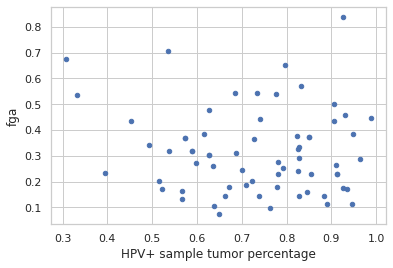

In [138]:
df_merged_HPVpos_fga_site_relative.plot(kind='scatter',y='fga',x='tumor',xlabel='HPV+ sample tumor percentage')

In [139]:
df_merged_HPVpos_fga_site_relative[['sample_match','fga','primary_site']]

,sample_match,fga,primary_site
0,TCGA-CN-5374,0.572,Oropharynx
1,TCGA-CR-5249,0.098,Oropharynx
2,TCGA-CV-6433,0.245,Oral Cavity
3,TCGA-H7-A76A,0.436,Oropharynx
4,TCGA-BB-4225,0.542,Oropharynx
...,...,...,...
62,TCGA-CN-A641,0.434,Larynx
63,TCGA-CN-4741,0.161,Oral Cavity
64,TCGA-CR-6472,0.377,Oropharynx
65,TCGA-CR-7404,0.538,Oropharynx


### Try to visualize Top Principle Component of 10 sets of cell type fractions for all samples
> Dim reduction to reduce features: 10 cell types as feature -> 1 PC as feature
 
>May help capture the hidden pattern within compositions

In [30]:
# pca and minmax scale
mmscaler = MinMaxScaler()

[0.52925429]


Text(0.5, 1.0, 'CNA-high group')

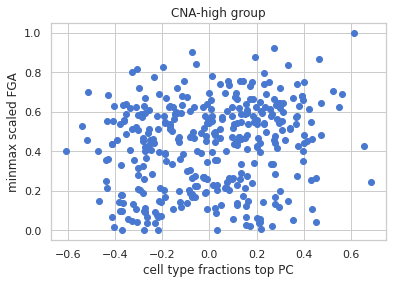

In [31]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='High'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=1)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat),mmscaler.fit_transform(df_afterSMOTE[df_afterSMOTE['FGA_status']=='High']['fga'].values.reshape(-1,1)))
plt.xlabel("cell type fractions top PC")
plt.ylabel("minmax scaled FGA")
plt.title("CNA-high group")

[0.63943834]


Text(0.5, 1.0, 'CNA-silent group')

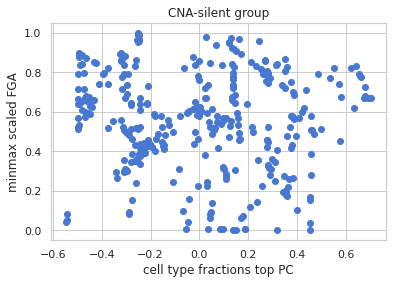

In [32]:
df_mat = df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent'].drop(['FGA_status','fga'],axis=1)
pca = PCA(n_components=1)
pca.fit(df_mat)
print(pca.explained_variance_ratio_)
plt.scatter(pca.transform(df_mat),mmscaler.fit_transform(df_afterSMOTE[df_afterSMOTE['FGA_status']=='Silent']['fga'].values.reshape(-1,1)))
plt.xlabel("cell type fractions top PC")
plt.ylabel("minmax scaled FGA")
plt.title("CNA-silent group")

### FGA high vs silent groups: TME shown per cell type per CNA group
- x-axis: FGA
- y-axis: minmax scaled cell type fractions, upper row of sub-plots: CNA-high, lower row of sub-plots: CNA-silent
- size and color of data points: cell type fractions

> Purpose of minmax scale normalization: hard to directly compare scatterplot with two different y-axis limits (0-0.2 and 0.2-1.0)

> Problem: data shown in this plot did not undergo SMOTE resampling so the 

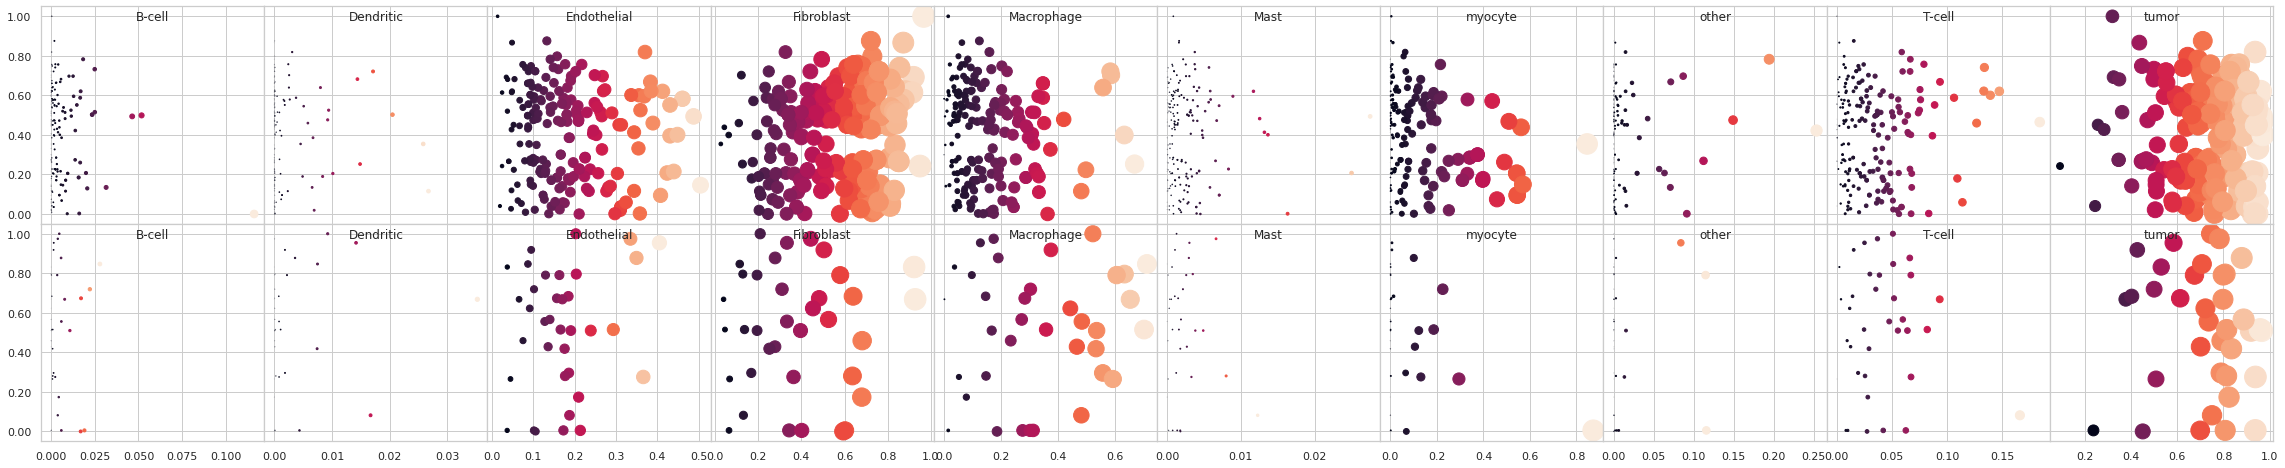

In [155]:
# Visualize fga high vs silent groups cell type compostions
fig,ax = plt.subplots(2,10,figsize=(40,8),sharey='row',sharex='col')
mmscaler = MinMaxScaler()
celltypecount = 10
count=0
for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='High']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='High'] # celltype fractions, non malignant relative 
    ax[0,count].scatter(z,y,c=z,s=z*500)
    ax[0,count].set_title(i,y=1.0, pad=-14)
    ax[0,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

for i in df_merged.columns[:celltypecount]:
    y = mmscaler.fit_transform(df_merged_HPVneg_fga_site_relative_OC['fga'][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent'].values.reshape(-1,1))
#     x = df_merged['cellularity'][df_merged['FGA_status']=='Silent']
    z = df_merged_HPVneg_fga_site_relative_OC[i][df_merged_HPVneg_fga_site_relative_OC['FGA_status']=='Silent']# celltype fractions, non malignant relative 
    ax[1,count].scatter(z,y,c=z,s=z*500)
    ax[1,count].set_title(i,y=1.0, pad=-14)
    ax[1,count].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    count+=1
count=0

plt.subplots_adjust(wspace=0, hspace=0)

## FGA distribution in HPV- tumors

In [36]:
df_merged_HPVneg_relative

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,cellularity,fga,FGA_status,sample_match
0,2.731707e-05,0.000095,0.244119,0.283693,0.309965,0.003196,9.356251e-02,2.613147e-04,0.065081,0.911705,TCGA-BB-4224-01,0.59,0.526,High,TCGA-BB-4224
1,5.081069e-03,0.001320,0.257672,0.114200,0.444937,0.026182,4.580000e-04,4.884700e-02,0.101304,0.942004,TCGA-H7-7774-01,0.48,0.169,Silent,TCGA-H7-7774
2,5.784423e-03,0.001777,0.063026,0.671513,0.237871,0.001418,7.390858e-04,5.536522e-07,0.017871,0.430702,TCGA-CV-6943-01,0.19,0.170,Silent,TCGA-CV-6943
4,3.880321e-06,0.000002,0.199913,0.496639,0.037901,0.001111,2.573028e-01,2.859005e-06,0.007125,0.549231,TCGA-CQ-6227-01,0.26,0.650,High,TCGA-CQ-6227
5,2.826607e-03,0.000006,0.224973,0.256350,0.159039,0.000825,3.410992e-01,4.595136e-06,0.014877,0.680641,TCGA-CV-6959-01,0.36,0.430,High,TCGA-CV-6959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,7.418559e-04,0.000275,0.312844,0.346991,0.158302,0.001420,1.326142e-01,5.582370e-03,0.041229,0.942446,TCGA-C9-A47Z-01,0.63,0.562,High,TCGA-C9-A47Z
479,1.491043e-02,0.000005,0.154127,0.236060,0.108300,0.001571,1.296746e-03,4.817653e-01,0.001965,0.593934,TCGA-CN-6010-01,0.36,0.736,High,TCGA-CN-6010
480,5.454056e-07,0.000013,0.104302,0.759402,0.117746,0.000915,6.073761e-07,1.114677e-06,0.017620,0.551284,TCGA-CV-7235-01,0.40,0.778,High,TCGA-CV-7235
481,1.467926e-02,0.001796,0.430551,0.276839,0.176143,0.000974,5.125722e-03,5.152918e-03,0.088738,0.926642,TCGA-CX-7086-01,0.61,0.642,High,TCGA-CX-7086


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='HPV- sample tumor percentage', ylabel='fga'>

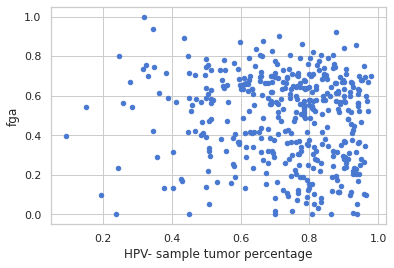

In [37]:
df_merged_HPVneg_relative.plot(kind='scatter',y='fga',x='tumor',xlabel='HPV- sample tumor percentage')

## Anatomical sites
-	Anatomical locations in groups on the x-axis and see for each (immune) cell type whether there are significant differences between anatomical sites (oral cavity, hypopharynx, larynx, oropharynx), all HPV-negative 

In [47]:
# All TCGA annotated primary sites
TCGA_pheno['primary_site'].value_counts()

Other and unspecified parts of tongue                                   158
Larynx                                                                  144
Other and ill-defined sites in lip, oral cavity and pharynx              90
Floor of mouth                                                           62
Tonsil                                                                   47
Other and unspecified parts of mouth                                     44
Base of tongue                                                           27
Gum                                                                      11
Oropharynx                                                               10
Hypopharynx                                                               9
Palate                                                                    6
Lip                                                                       3
Bones, joints and articular cartilage of other and unspecified sites      1
Name: primar

In [56]:
dict_primary_site = {'Alveolar Ridge': 'Oral Cavity',
 'Floor of mouth': 'Oral Cavity',
 'Palate': 'Oral Cavity',
 'Lip': 'Oral Cavity',
 'Oral Tongue': 'Oral Cavity',
 'Oral Cavity': 'Oral Cavity',
 'Other and unspecified parts of tongue': 'Oral Cavity',
 'Other and unspecified parts of mouth': 'Oral Cavity',
 'Base of tongue': 'Oropharynx',
 'Tonsil': 'Oropharynx',
 'Oropharynx': 'Oropharynx',
    'Larynx': 'Larynx',    
    'Floor of mouth':'Oral Cavity',
    'Gum':'Oral Cavity',
    'Oropharynx':'Oropharynx',
    'Hypopharynx':'Hypopharynx',
                    }

In [57]:
TCGA_pheno_new = TCGA_pheno.copy()
TCGA_pheno_new['primary_site'] = TCGA_pheno_new['primary_site'].map(dict_primary_site)
TCGA_pheno_new.dropna(subset='primary_site',inplace=True)
TCGA_pheno_new['primary_site'].value_counts()

Oral Cavity    284
Larynx         144
Oropharynx      84
Hypopharynx      9
Name: primary_site, dtype: int64

In [58]:
df_merged_sites = pd.merge(res_prevail,TCGA_pheno_new[['submitter_id.samples','primary_site']],left_index=True,right_on='submitter_id.samples')
# df_merged_sites

In [59]:
df_merged_sites_HPVpos = df_merged_sites.copy()
df_merged_sites_HPVpos['sample_match'] = df_merged_sites['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites_HPVpos = df_merged_sites_HPVpos[df_merged_sites_HPVpos['sample_match'].isin(set_pos)]
# df_merged_sites_HPVpos

In [60]:
# we will only use HPV- samples here
df_merged_sites_HPVneg = df_merged_sites.copy()
df_merged_sites_HPVneg['sample_match'] = df_merged_sites['sample'].str.rsplit("-",n=1,expand=True)[0]
df_merged_sites_HPVneg = df_merged_sites_HPVneg[~df_merged_sites_HPVneg['sample_match'].isin(set_pos)]
# df_merged_sites_HPVneg

In [66]:
df_merged_sites_HPVpos_relative = df_merged_sites_HPVpos.copy()
df_merged_sites_HPVpos_relative.iloc[:,:9] = df_merged_sites_HPVpos_relative.iloc[:,:9].div(df_merged_sites_HPVpos_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVpos_relative

In [67]:
df_merged_sites_HPVneg_relative = df_merged_sites_HPVneg.copy()
df_merged_sites_HPVneg_relative.iloc[:,:9] = df_merged_sites_HPVneg_relative.iloc[:,:9].div(df_merged_sites_HPVneg_relative.iloc[:,:9].sum(axis=1),axis=0)
# df_merged_HPVneg_relative

### Statistics of primary sites in HPV- subgroup

In [61]:
df_merged_sites_HPVneg['primary_site'].value_counts()
# need to filter out sites with too less samples

Oral Cavity    243
Larynx         120
Oropharynx      25
Hypopharynx      7
Name: primary_site, dtype: int64

### remove primary site with sample counts<=10
## DEPRECATED!

In [55]:
# df_merged_sites_HPVneg_filtered = df_merged_sites_HPVneg.groupby("primary_site").filter(lambda x: len(x) >10)
# df_merged_sites_HPVneg_filtered['primary_site'].value_counts()

Other and unspecified parts of tongue                          131
Larynx                                                         120
Other and ill-defined sites in lip, oral cavity and pharynx     77
Floor of mouth                                                  56
Other and unspecified parts of mouth                            41
Base of tongue                                                  11
Name: primary_site, dtype: int64

In [68]:
df_merged_sites_HPVneg_melt = pd.melt(df_merged_sites_HPVneg_relative,id_vars='primary_site',value_vars=df_merged_sites_HPVneg_relative.columns[:10].tolist())
# df_merged_sites_HPVneg_melt

Text(0, 0.5, 'Cell type fractions')

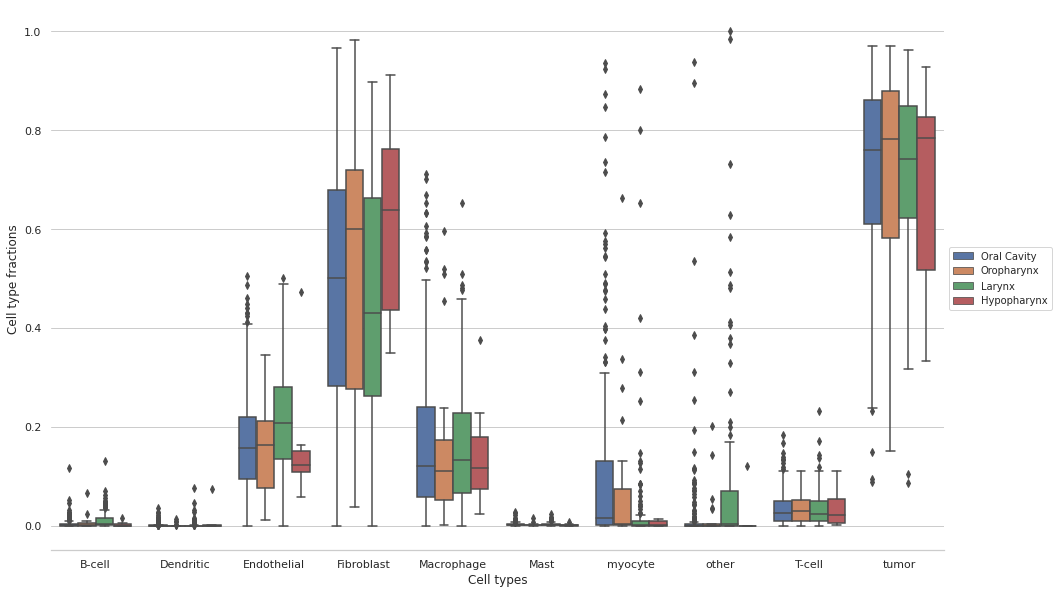

In [69]:
plt.subplots(figsize=(16,10))
sns.boxplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

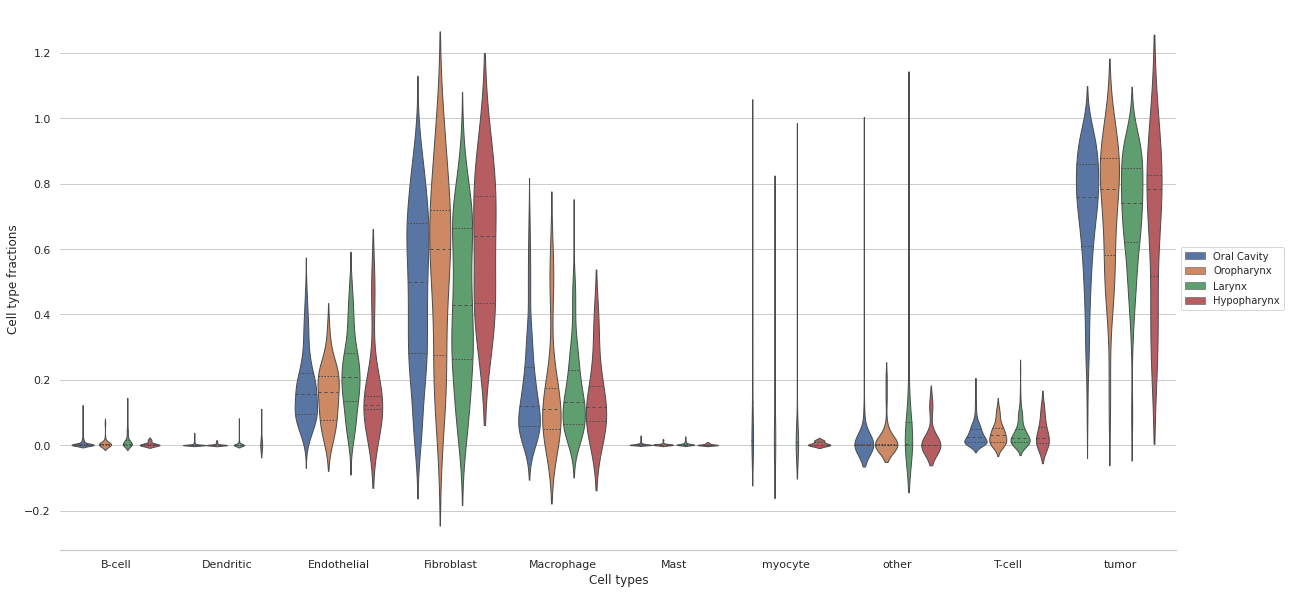

In [70]:
plt.subplots(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='primary_site',data=df_merged_sites_HPVneg_melt, inner="quart", linewidth=1,)
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=10)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [71]:
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_merged_sites_HPVneg_relative.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_merged_sites_HPVneg_relative.loc[:,list_col].to_numpy(),df_merged_sites_HPVneg_relative['primary_site'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 972
Oral Cavity    243
Oropharynx     243
Larynx         243
Hypopharynx    243
Name: primary_site, dtype: int64


In [72]:
df_afterSMOTE_site = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_site['primary_site'] = y_train
# df_afterSMOTE_site

In [74]:
df_afterSMOTE_melt_site = pd.melt(df_afterSMOTE_site,id_vars='primary_site',value_vars=df_merged_sites_HPVneg_relative.columns[:10].tolist())
# df_afterSMOTE_melt_site

In [75]:
df_afterSMOTE_melt_site_log = df_afterSMOTE_melt_site.copy()
df_afterSMOTE_melt_site_log['value'] = df_afterSMOTE_melt_site_log['value'].apply(np.log)

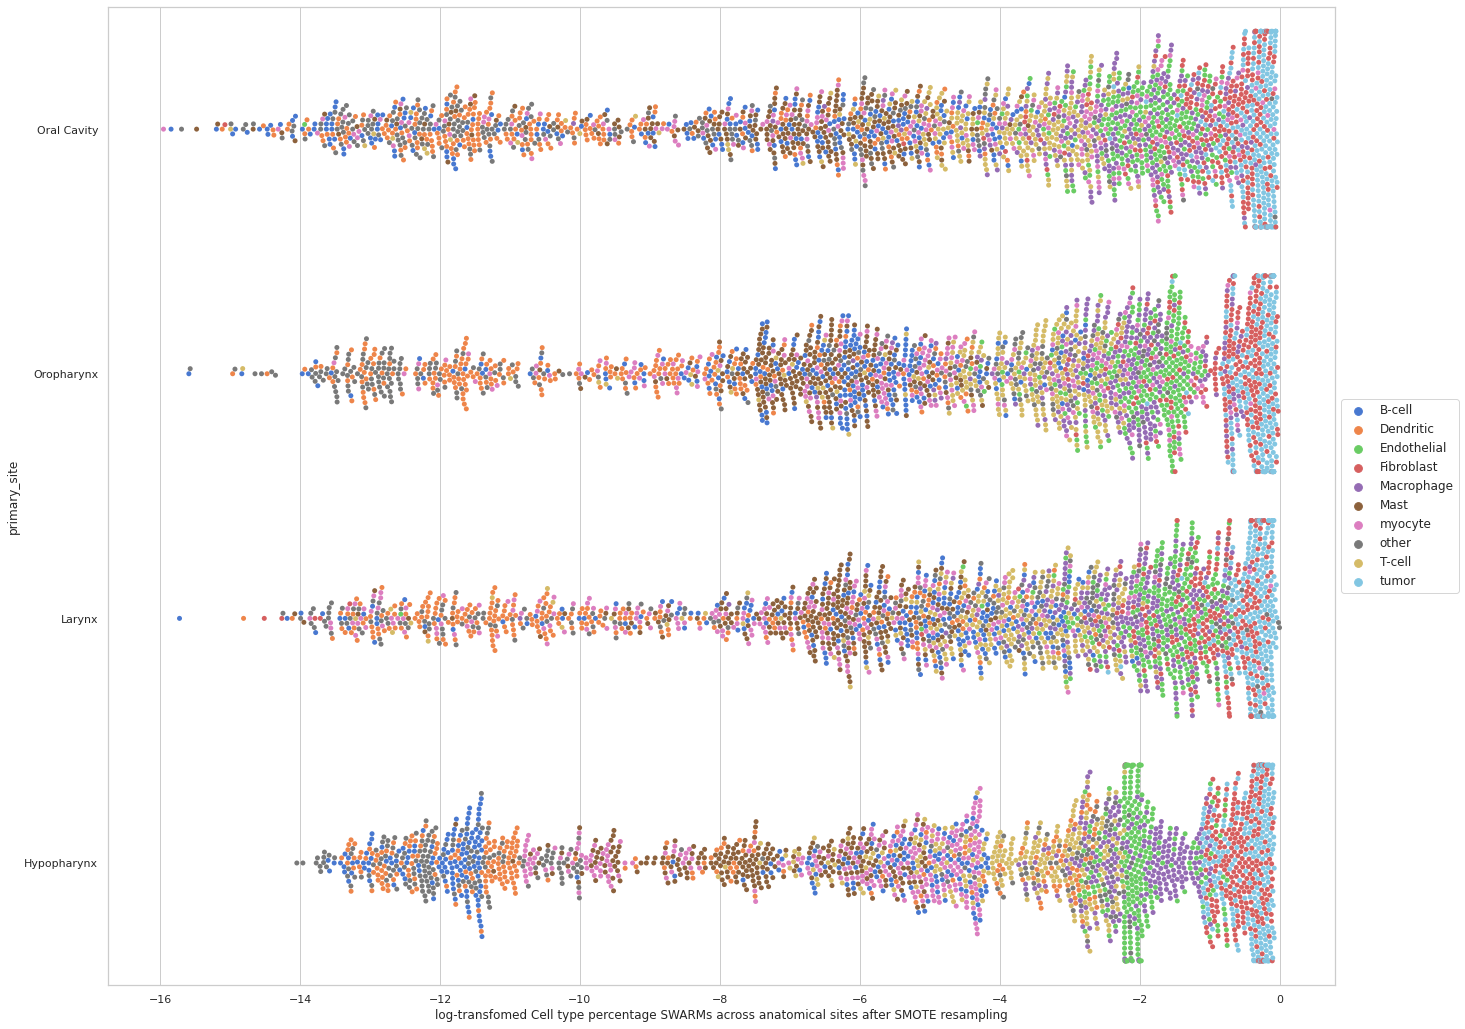

In [78]:
# Draw a categorical scatterplot to show each observation
plt.subplots(figsize=(22,18))
sns.set_theme(style="whitegrid", palette="muted")
ax = sns.swarmplot(data=df_afterSMOTE_melt_site_log, x="value", y="primary_site", hue="variable")
ax.set(xlabel="log-transfomed Cell type percentage SWARMs across anatomical sites after SMOTE resampling")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)

###	HPV-positive versus HPV-negative oropharynx tumors (no other anatomical sites here)
> list of Oropharynx samples identified

In [79]:
list_oropharynx = TCGA_pheno_new[TCGA_pheno_new['primary_site']=='Oropharynx']['sample'].tolist()
list_oropharynx

['TCGA-BA-A4IH',
 'TCGA-HD-8224',
 'TCGA-H7-A76A',
 'TCGA-F7-A61V',
 'TCGA-BB-7871',
 'TCGA-MZ-A5BI',
 'TCGA-CR-6478',
 'TCGA-CR-5249',
 'TCGA-CR-6477',
 'TCGA-IQ-A61I',
 'TCGA-CV-5439',
 'TCGA-CV-5439',
 'TCGA-CR-6472',
 'TCGA-HD-7753',
 'TCGA-BB-A6UM',
 'TCGA-F7-A620',
 'TCGA-BB-7861',
 'TCGA-CR-7404',
 'TCGA-BA-A8YP',
 'TCGA-RS-A6TP',
 'TCGA-HD-8314',
 'TCGA-P3-A5QE',
 'TCGA-P3-A5Q5',
 'TCGA-CR-6480',
 'TCGA-HD-7754',
 'TCGA-CN-A6V7',
 'TCGA-CN-5374',
 'TCGA-QK-A8ZA',
 'TCGA-HD-A634',
 'TCGA-QK-A6V9',
 'TCGA-MZ-A6I9',
 'TCGA-DQ-7594',
 'TCGA-QK-A6IF',
 'TCGA-DQ-7591',
 'TCGA-DQ-7596',
 'TCGA-CV-6943',
 'TCGA-CV-6943',
 'TCGA-BB-4228',
 'TCGA-MZ-A7D7',
 'TCGA-T2-A6X0',
 'TCGA-CR-6481',
 'TCGA-CR-6470',
 'TCGA-DQ-7593',
 'TCGA-CR-5247',
 'TCGA-T2-A6WZ',
 'TCGA-CR-7383',
 'TCGA-IQ-A61O',
 'TCGA-MT-A51W',
 'TCGA-BB-4225',
 'TCGA-CR-6467',
 'TCGA-BA-A4IF',
 'TCGA-BA-A4II',
 'TCGA-BA-A4IG',
 'TCGA-CR-6482',
 'TCGA-BA-6871',
 'TCGA-KU-A6H7',
 'TCGA-KU-A6H7',
 'TCGA-CN-A6V6',
 'TCGA-DQ-7590

In [80]:
df_oro_pos = df_merged_sites_HPVpos_relative[df_merged_sites_HPVpos_relative['sample_match'].isin(list_oropharynx)]
df_oro_pos.loc[:,'hpv_status'] = 'Positive'

/tmp/ipykernel_31417/4276770188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oro_pos.loc[:,'hpv_status'] = 'Positive'


In [81]:
df_oro_neg = df_merged_sites_HPVneg_relative[df_merged_sites_HPVneg_relative['sample_match'].isin(list_oropharynx)]
df_oro_neg.loc[:,'hpv_status'] = 'Negative'

/tmp/ipykernel_31417/1785884867.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oro_neg.loc[:,'hpv_status'] = 'Negative'


In [82]:
df_oro = pd.concat([df_oro_neg,df_oro_pos],axis=0)
# df_oro

In [83]:
df_oro['hpv_status'].value_counts()

Positive    48
Negative    25
Name: hpv_status, dtype: int64

In [84]:
df_oro_melt = pd.melt(df_oro,id_vars='hpv_status',value_vars=df_merged_sites_HPVneg_relative.columns[:10].tolist())
# df_oro_melt

Text(0, 0.5, 'Cell type fractions')

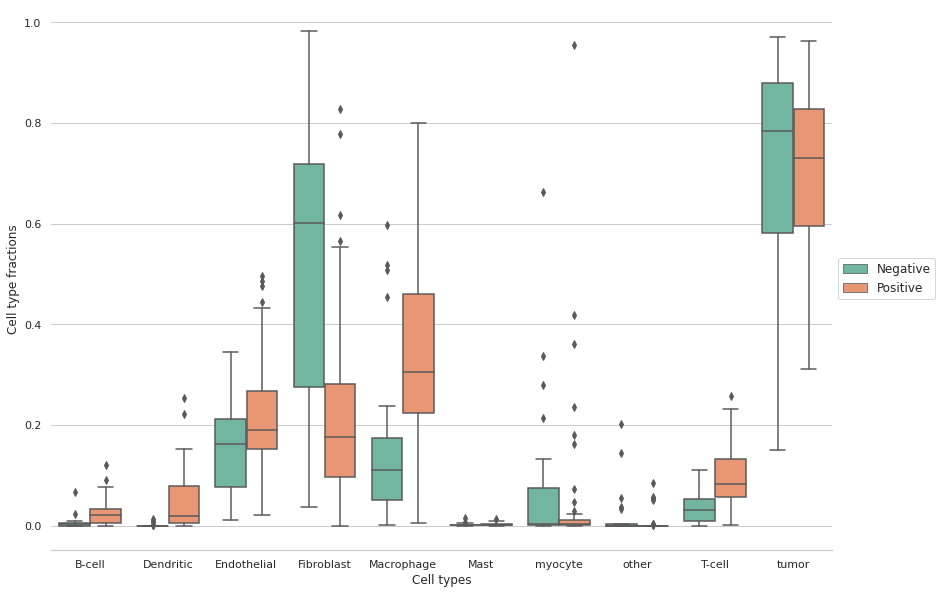

In [88]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

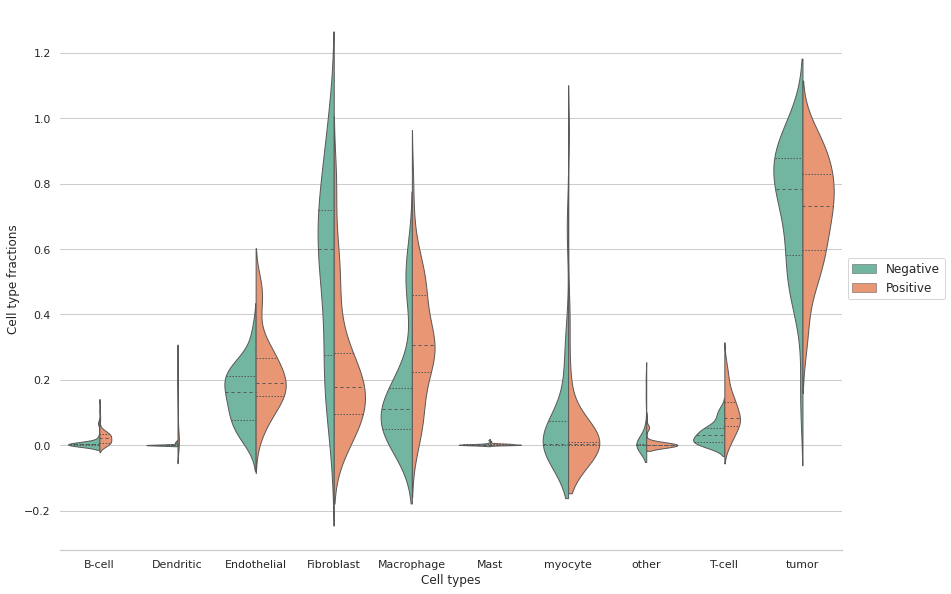

In [89]:
plt.subplots(figsize=(14,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='hpv_status',data=df_oro_melt, inner="quart", split=True,linewidth=1,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

In [90]:
df_oro

,B-cell,Dendritic,Endothelial,Fibroblast,Macrophage,Mast,myocyte,other,T-cell,tumor,sample,submitter_id.samples,primary_site,sample_match,hpv_status
327,0.005784,0.001777,0.063026,0.671513,0.237871,0.001418,0.000739,5.536522e-07,0.017871,0.430702,TCGA-CV-6943-01,TCGA-CV-6943-01A,Oropharynx,TCGA-CV-6943,Negative
37,0.004797,0.000016,0.170192,0.236824,0.064370,0.000348,0.336547,1.438250e-01,0.043081,0.876706,TCGA-F7-A61V-01,TCGA-F7-A61V-01A,Oropharynx,TCGA-F7-A61V,Negative
604,0.000012,0.000006,0.149431,0.707506,0.001335,0.001013,0.131347,1.204861e-05,0.009338,0.809875,TCGA-P3-A6SX-01,TCGA-P3-A6SX-01A,Oropharynx,TCGA-P3-A6SX,Negative
344,0.004653,0.000142,0.243094,0.477911,0.110190,0.015644,0.001352,3.617283e-02,0.110840,0.970448,TCGA-MZ-A7D7-01,TCGA-MZ-A7D7-01A,Oropharynx,TCGA-MZ-A7D7,Negative
361,0.066929,0.000032,0.211246,0.516333,0.139455,0.001247,0.009595,2.703122e-05,0.055136,0.878481,TCGA-T2-A6WZ-01,TCGA-T2-A6WZ-01A,Oropharynx,TCGA-T2-A6WZ,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.029666,0.009504,0.247367,0.203032,0.444289,0.003643,0.000111,3.681835e-06,0.062385,0.394372,TCGA-CR-6482-01,TCGA-CR-6482-01A,Oropharynx,TCGA-CR-6482,Positive
82,0.005476,0.000011,0.143906,0.778040,0.039059,0.003852,0.003607,1.086596e-05,0.026038,0.822699,TCGA-CR-6472-01,TCGA-CR-6472-01A,Oropharynx,TCGA-CR-6472,Positive
434,0.004278,0.109582,0.154265,0.040189,0.557014,0.003875,0.005207,9.047028e-06,0.125581,0.913220,TCGA-KU-A6H7-06,TCGA-KU-A6H7-06A,Oropharynx,TCGA-KU-A6H7,Positive
126,0.035211,0.006584,0.265301,0.245341,0.352033,0.004034,0.001004,7.586615e-05,0.090416,0.775319,TCGA-CR-7404-01,TCGA-CR-7404-01A,Oropharynx,TCGA-CR-7404,Positive


In [91]:
# try oversampling HPV status, prove SMOTE does not amplify or cause change of pattern
## Vis Methods below need resampling!
# SMOTE upsample CNA silent group

sm = imblearn.over_sampling.SMOTE()
list_col = df_oro.columns[:10].tolist()

X_train, y_train = sm.fit_resample(df_oro.loc[:,list_col].to_numpy(),df_oro['hpv_status'])
print('Resampled dataset shape %s' % len(y_train))
print(y_train.value_counts())

Resampled dataset shape 96
Negative    48
Positive    48
Name: hpv_status, dtype: int64


In [93]:
df_afterSMOTE_hpv_oro = pd.DataFrame(X_train,columns=list_col)
df_afterSMOTE_hpv_oro['hpv_status'] = y_train
df_afterSMOTE_hpv_oro_melt = pd.melt(df_afterSMOTE_hpv_oro,id_vars='hpv_status',value_vars=df_afterSMOTE_hpv_oro.columns[:10].tolist())
# df_afterSMOTE_melt_site

Text(0, 0.5, 'Cell type fractions')

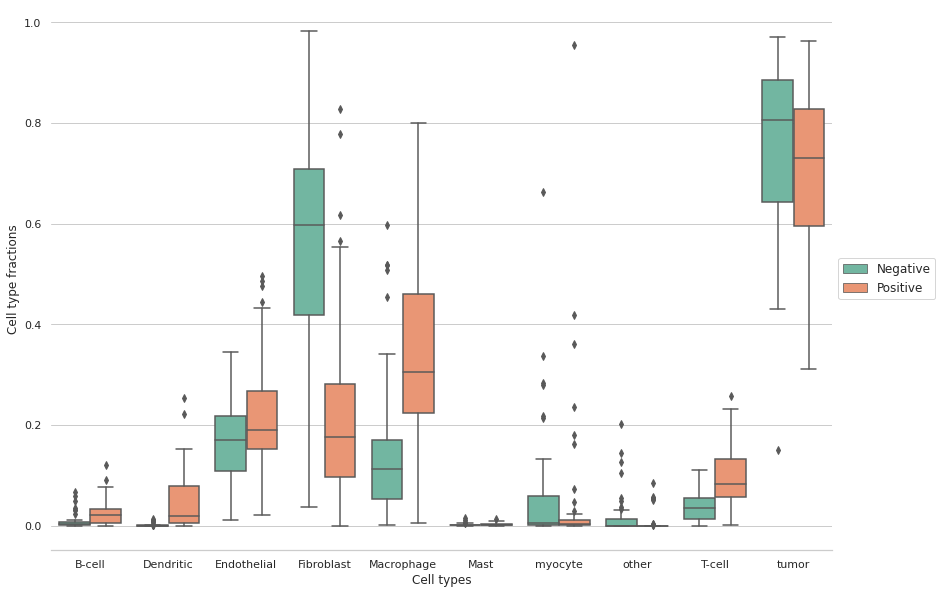

In [94]:
plt.subplots(figsize=(14,10))
sns.boxplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_melt,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")

Text(0, 0.5, 'Cell type fractions')

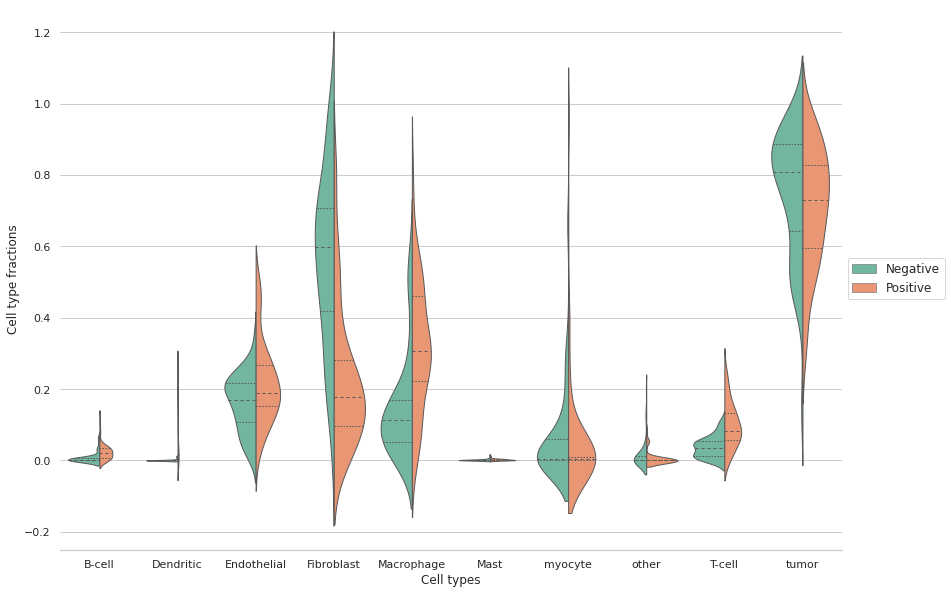

In [95]:
plt.subplots(figsize=(14,10))
sns.set_theme(style="whitegrid")
sns.violinplot(x='variable',y='value',hue='hpv_status',data=df_afterSMOTE_hpv_oro_melt, inner="quart", split=True,linewidth=1,palette="Set2")
sns.despine(left=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=12)
plt.xlabel("Cell types")
plt.ylabel("Cell type fractions")